Load toolboxes:

In [1]:
import helper
import plot_settings

# import packages
import pymaid
import navis
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.stats import pearsonr, ttest_ind
from scipy.optimize import lsq_linear
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import r2_score

path_plots = 'plots/'

# Set matplotlib style
plt.rcParams.update(plot_settings.params)

### Load the required data from the server:

In [2]:
# load the remote instance of pymaid to the server
l1em = pymaid.connect_catmaid(server="https://l1em.catmaid.virtualflybrain.org/", api_token=None, max_threads=50, caching=False)    # L1 Larval CNS
l3vnc = pymaid.connect_catmaid(server="https://l3vnc.catmaid.virtualflybrain.org/", api_token=None, max_threads=50, caching=False, project_id=2)  # L3 Larval VNC

neurons_str = 'Gerhard et al. 2017'

# load neurons
# l1_neurons = pymaid.get_neurons('annotations:' + neurons_str, remote_instance=l1em)
l1_neurons = helper.try_with_retries(pymaid.get_neurons, 5, 'annotations:' + neurons_str, remote_instance=l1em)
l1_neurons.set_neuron_attributes(neurons_str, 'annotation')
# l3_neurons = pymaid.get_neurons('annotations:' + neurons_str, remote_instance=l3vnc)
l3_neurons = helper.try_with_retries(pymaid.get_neurons, 5, 'annotations:' + neurons_str, remote_instance=l3vnc)
l3_neurons.set_neuron_attributes(neurons_str, 'annotation')

# replace ' ' in all the names with '_' to match the names in the database
for neuron in l1_neurons:
    neuron.name = '_'.join(neuron.name.replace(' ', '_').split('_')[:2])
for neuron in l3_neurons:
    neuron.name = '_'.join(neuron.name.replace(' ', '_').split('_')[:2])

# filter out neurons without 'a1' or 'a3' in the name
for neuron in l1_neurons:
    if 'a1' not in neuron.name:
        l1_neurons -= neuron
for neuron in l3_neurons:
    if 'a3' not in neuron.name:
        l3_neurons -= neuron

INFO  : Global CATMAID instance set. Caching is OFF. (pymaid)
INFO  : Global CATMAID instance set. Caching is OFF. (pymaid)


Fetch neurons:   0%|          | 0/55 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/55 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/18 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/18 [00:00<?, ?it/s]

Organise the neuron cell types:

In [3]:
# Get mdIV (ddaC, v'ada and vdaB) neurons in L1 and L3
l1_ddaC_neurons = helper.filter_neurons(l1_neurons, 'ddaC')
l1_vada_neurons = helper.filter_neurons(l1_neurons, 'v\'ada')
l1_vdaB_neurons = helper.filter_neurons(l1_neurons, 'vdaB')
l3_ddaC_neurons = helper.filter_neurons(l3_neurons, 'ddaC')
l3_vada_neurons = helper.filter_neurons(l3_neurons, 'v\'ada')
l3_vdaB_neurons = helper.filter_neurons(l3_neurons, 'vdaB')

l1_mdIV_neurons = l1_ddaC_neurons + l1_vada_neurons + l1_vdaB_neurons
l3_mdIV_neurons = l3_ddaC_neurons + l3_vada_neurons + l3_vdaB_neurons

# Get LNs (A02n, A09a, A09c, A09l, A10a) neurons in L1 and L3
l1_A02n_neurons = helper.filter_neurons(l1_neurons, 'A02n')
l1_A02m_neurons = helper.filter_neurons(l1_neurons, 'A02m')
l1_A09a_neurons = helper.filter_neurons(l1_neurons, 'A09a')
l1_A09c_neurons = helper.filter_neurons(l1_neurons, 'A09c')
l1_A09l_neurons = helper.filter_neurons(l1_neurons, 'A09l')
l1_A10a_neurons = helper.filter_neurons(l1_neurons, 'A10a')

l3_A02n_neurons = helper.filter_neurons(l3_neurons, 'A02n')
l3_A02m_neurons = helper.filter_neurons(l3_neurons, 'A02m')
l3_A09a_neurons = helper.filter_neurons(l3_neurons, 'A09a')
l3_A09c_neurons = helper.filter_neurons(l3_neurons, 'A09c')
l3_A09l_neurons = helper.filter_neurons(l3_neurons, 'A09l')
l3_A10a_neurons = helper.filter_neurons(l3_neurons, 'A10a')

l1_LN_neurons = l1_A02n_neurons + l1_A02m_neurons + l1_A09a_neurons + l1_A09c_neurons + l1_A09l_neurons + l1_A10a_neurons
l3_LN_neurons = l3_A02n_neurons + l3_A02m_neurons + l3_A09a_neurons + l3_A09c_neurons + l3_A09l_neurons + l3_A10a_neurons

# sort all the neurons by name (left to right)
for neuron in [l1_ddaC_neurons, l1_vada_neurons, l1_vdaB_neurons, l3_ddaC_neurons, l3_vada_neurons, l3_vdaB_neurons,    # mdIVs
                l1_A02n_neurons, l1_A09a_neurons, l1_A09c_neurons, l1_A09l_neurons, l1_A10a_neurons, l3_A02n_neurons, l3_A09a_neurons, l3_A09c_neurons, l3_A09l_neurons, l3_A10a_neurons, # LNs
                l1_mdIV_neurons, l3_mdIV_neurons, l1_LN_neurons, l3_LN_neurons,
                ]:
    neuron.sort_values(key='name', ascending=True)

# create color dictionary for the neurons
for source_name in l1_mdIV_neurons.name:
    plot_settings.neuron_dict[source_name] = plot_settings.neuron_dict[source_name.split('_')[0]]
for target_name in l1_LN_neurons.name:
    plot_settings.neuron_dict[target_name] = plot_settings.neuron_dict[target_name.split('_')[0]]
# create color dictionary for the neurons
for source_name in l3_mdIV_neurons.name:
    plot_settings.neuron_dict[source_name] = plot_settings.neuron_dict[source_name.split('_')[0]]
for target_name in l3_LN_neurons.name:
    plot_settings.neuron_dict[target_name] = plot_settings.neuron_dict[target_name.split('_')[0]]

# Select one LN for the visualization
l1_selected = l1_LN_neurons[9]
print(l1_selected.name)
l3_selected = l3_LN_neurons[9]
print(l3_selected.name)

A09l_a1r
A09l_a3r


In [4]:
###########################################################
# Actual synapses
# l1_actual_syn = pymaid.get_connectors_between(l1_mdIV_neurons, l1_LN_neurons, remote_instance=l1em)
l1_actual_syn = helper.try_with_retries(pymaid.get_connectors_between, 5, l1_mdIV_neurons, l1_LN_neurons, remote_instance=l1em)
# l3_actual_syn = pymaid.get_connectors_between(l3_mdIV_neurons, l3_LN_neurons, remote_instance=l3vnc)
l3_actual_syn = helper.try_with_retries(pymaid.get_connectors_between, 5, l3_mdIV_neurons, l3_LN_neurons, remote_instance=l3vnc)

# add name tags of source and target neurons
l1_actual_syn['source_name'] = [l1_mdIV_neurons[l1_mdIV_neurons.skeleton_id == str(id)].name[0] for id in l1_actual_syn.source_neuron]
l1_actual_syn['target_name'] = [l1_LN_neurons[l1_LN_neurons.skeleton_id == str(id)].name[0] for id in l1_actual_syn.target_neuron]
l3_actual_syn['source_name'] = [l3_mdIV_neurons[l3_mdIV_neurons.skeleton_id == str(id)].name[0] for id in l3_actual_syn.source_neuron]
l3_actual_syn['target_name'] = [l3_LN_neurons[l3_LN_neurons.skeleton_id == str(id)].name[0] for id in l3_actual_syn.target_neuron]

###########################################################
# Adjacency
# L1
# l1_adjacency = pymaid.adjacency_matrix(l1_mdIV_neurons, l1_LN_neurons, remote_instance=l1em)
l1_adjacency = helper.try_with_retries(pymaid.adjacency_matrix, 5, l1_mdIV_neurons, l1_LN_neurons, remote_instance=l1em)
l1_adjacency.index = [l1_mdIV_neurons[l1_mdIV_neurons.skeleton_id == str(id)].name[0] for id in l1_adjacency.index]
l1_adjacency.columns = [l1_LN_neurons[l1_LN_neurons.skeleton_id == str(id)].name[0] for id in l1_adjacency.columns]
# L3
# l3_adjacency = pymaid.adjacency_matrix(l3_mdIV_neurons, l3_LN_neurons, remote_instance=l3vnc)
l3_adjacency = helper.try_with_retries(pymaid.adjacency_matrix, 5, l3_mdIV_neurons, l3_LN_neurons, remote_instance=l3vnc)
l3_adjacency.index = [l3_mdIV_neurons[l3_mdIV_neurons.skeleton_id == str(id)].name[0] for id in l3_adjacency.index]
l3_adjacency.columns = [l3_LN_neurons[l3_LN_neurons.skeleton_id == str(id)].name[0] for id in l3_adjacency.columns]

###############################################################
# Adjacency normalized by the number of postsynapses
# Create table for each LN neuron with the total amount of presynapses and postsynapses
l1_LN_all_syn = pd.DataFrame({'name': l1_LN_neurons.name, 'presynapses': [len(neuron.presynapses) for neuron in l1_LN_neurons], 'postsynapses': [len(neuron.postsynapses) for neuron in l1_LN_neurons]})
l3_LN_all_syn = pd.DataFrame({'name': l3_LN_neurons.name, 'presynapses': [len(neuron.presynapses) for neuron in l3_LN_neurons], 'postsynapses': [len(neuron.postsynapses) for neuron in l3_LN_neurons]})

# cut of the names at the second underscore
l1_LN_all_syn['name'] = ['_'.join(name.split('_')[:2]) for name in l1_LN_all_syn['name']]
l3_LN_all_syn['name'] = ['_'.join(name.split('_')[:2]) for name in l3_LN_all_syn['name']]
# set the names as index
l1_LN_all_syn = l1_LN_all_syn.set_index('name')
l3_LN_all_syn = l3_LN_all_syn.set_index('name')

l1_adjacency_norm = l1_adjacency / l1_LN_all_syn.postsynapses
l3_adjacency_norm = l3_adjacency / l3_LN_all_syn.postsynapses

###########################################################
# Splitted neurons
# l1_split_all = navis.morpho.split_axon_dendrite(l1_LN_neurons, reroot_soma=True, cellbodyfiber='soma')
l1_split_all = helper.try_with_retries(navis.morpho.split_axon_dendrite, 5, l1_LN_neurons, reroot_soma=True, cellbodyfiber='soma')
# l3_split_all = navis.morpho.split_axon_dendrite(l3_LN_neurons, reroot_soma=True, cellbodyfiber='soma')
l3_split_all = helper.try_with_retries(navis.morpho.split_axon_dendrite, 5, l3_LN_neurons, reroot_soma=True, cellbodyfiber='soma')

l1_LN_axon = l1_split_all[l1_split_all.compartment == 'axon']
l1_LN_dendrite = l1_split_all[l1_split_all.compartment == 'dendrite']
l1_LN_rest = l1_split_all[(l1_split_all.compartment != 'axon') & (l1_split_all.compartment != 'dendrite')]

l3_LN_axon = l3_split_all[l3_split_all.compartment == 'axon']
l3_LN_dendrite = l3_split_all[l3_split_all.compartment == 'dendrite']
l3_LN_rest = l3_split_all[(l3_split_all.compartment != 'axon') & (l3_split_all.compartment != 'dendrite')]

all_neurons_split = l1_split_all + l3_split_all
all_neurons_dend = all_neurons_split[all_neurons_split.compartment == 'dendrite']

# l1_n_pruned = navis.split_axon_dendrite(l1_mdIV_neurons, metric='bending_flow', split='distance')
l1_n_pruned = helper.try_with_retries(navis.split_axon_dendrite, 5, l1_mdIV_neurons, metric='bending_flow', split='distance')
l1_n_dend = l1_n_pruned[l1_n_pruned.compartment == 'dendrite']
l1_n_axon = l1_n_pruned[l1_n_pruned.compartment == 'axon']

# l3_n_pruned = navis.split_axon_dendrite(l3_mdIV_neurons, metric='bending_flow', split='distance')
l3_n_pruned = helper.try_with_retries(navis.split_axon_dendrite, 5, l3_mdIV_neurons, metric='bending_flow', split='distance')
l3_n_dend = l3_n_pruned[l3_n_pruned.compartment == 'dendrite']
l3_n_axon = l3_n_pruned[l3_n_pruned.compartment == 'axon']

Splitting:   0%|          | 0/12 [00:00<?, ?it/s]

Splitting:   0%|          | 0/12 [00:00<?, ?it/s]

Splitting:   0%|          | 0/6 [00:00<?, ?it/s]

Splitting:   0%|          | 0/6 [00:00<?, ?it/s]

Resample neuron skeletons and split morphology:

In [5]:
rs_res = '0.1 micron'

l1_LN_neurons_rs = l1_LN_neurons.copy()
l1_LN_neurons_rs = l1_LN_neurons_rs.convert_units('um')
l1_LN_neurons_rs = l1_LN_neurons_rs.resample(rs_res)

l3_LN_neurons_rs = l3_LN_neurons.copy()
l3_LN_neurons_rs = l3_LN_neurons_rs.convert_units('um')
l3_LN_neurons_rs = l3_LN_neurons_rs.resample(rs_res)

# l1_split_all_rs = navis.morpho.split_axon_dendrite(l1_LN_neurons_rs, reroot_soma=True, cellbodyfiber='soma')
l1_split_all_rs = helper.try_with_retries(navis.morpho.split_axon_dendrite, 5, l1_LN_neurons_rs, reroot_soma=True, cellbodyfiber='soma')
# l3_split_all_rs = navis.morpho.split_axon_dendrite(l3_LN_neurons_rs, reroot_soma=True, cellbodyfiber='soma')
l3_split_all_rs = helper.try_with_retries(navis.morpho.split_axon_dendrite, 5, l3_LN_neurons_rs, reroot_soma=True, cellbodyfiber='soma')

l1_LN_dends_rs = l1_split_all_rs[l1_split_all_rs.compartment == 'dendrite']
l1_LN_axons_rs = l1_split_all_rs[l1_split_all_rs.compartment == 'axon']
l3_LN_dends_rs = l3_split_all_rs[l3_split_all_rs.compartment == 'dendrite']
l3_LN_axons_rs = l3_split_all_rs[l3_split_all_rs.compartment == 'axon']

convert_units:   0%|          | 0/12 [00:00<?, ?it/s]

resample:   0%|          | 0/12 [00:00<?, ?it/s]

convert_units:   0%|          | 0/12 [00:00<?, ?it/s]

resample:   0%|          | 0/12 [00:00<?, ?it/s]

Splitting:   0%|          | 0/12 [00:00<?, ?it/s]

Splitting:   0%|          | 0/12 [00:00<?, ?it/s]

Then all mdIVs:

In [6]:
l1_all_axons_rs = l1_mdIV_neurons.copy()
l1_all_axons_rs = l1_all_axons_rs.convert_units('um')
l1_all_axons_rs = l1_all_axons_rs.resample(rs_res)

l3_all_axons_rs = l3_mdIV_neurons.copy()
l3_all_axons_rs = l3_all_axons_rs.convert_units('um')
l3_all_axons_rs = l3_all_axons_rs.resample(rs_res)

convert_units:   0%|          | 0/6 [00:00<?, ?it/s]

resample:   0%|          | 0/6 [00:00<?, ?it/s]

convert_units:   0%|          | 0/6 [00:00<?, ?it/s]

resample:   0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
overlap_dist = '500 nanometer'

# Get overlapping cable within 2 microns
l1_overlap_all, l1_overlap_all_loc = helper.get_cable_overlap_and_ids(l1_all_axons_rs, l1_LN_dends_rs, dist=overlap_dist, method='forward')
l1_overlap_all = l1_overlap_all.T

l3_overlap_all, l3_overlap_all_loc = helper.get_cable_overlap_and_ids(l3_all_axons_rs, l3_LN_dends_rs, dist=overlap_dist, method='forward')
l3_overlap_all = l3_overlap_all.T

l1_overlap_all.columns = [l1_mdIV_neurons[l1_mdIV_neurons.skeleton_id == str(id)].name[0].split('_')[0] for id in l1_overlap_all.columns]
l1_overlap_all.index = [l1_LN_neurons[l1_LN_neurons.skeleton_id == str(id)].name[0].split('_')[0] for id in l1_overlap_all.index]
l3_overlap_all.columns = [l3_mdIV_neurons[l3_mdIV_neurons.skeleton_id == str(id)].name[0].split('_')[0] for id in l3_overlap_all.columns]
l3_overlap_all.index = [l3_LN_neurons[l3_LN_neurons.skeleton_id == str(id)].name[0].split('_')[0] for id in l3_overlap_all.index]

# Compute amount of cable that is in proximity but now using the dendrites themself.
# This can be used as maximum to normalize or calculate the ratio of how much they overlap with the axons.
l1_overlap_dend, l1_overlap_dend_loc = helper.get_cable_overlap_and_ids(l1_LN_dends_rs, l1_LN_dends_rs, dist=overlap_dist, method='forward')
l3_overlap_dend, l3_overlap_dend_loc = helper.get_cable_overlap_and_ids(l3_LN_dends_rs, l3_LN_dends_rs, dist=overlap_dist, method='forward')

l1_overlap_dend.index = [l1_LN_neurons[l1_LN_neurons.skeleton_id == str(id)].name[0].split('_')[0] for id in l1_overlap_dend.index]
l1_overlap_dend.columns = [l1_LN_neurons[l1_LN_neurons.skeleton_id == str(id)].name[0].split('_')[0] for id in l1_overlap_dend.columns]
l3_overlap_dend.index = [l3_LN_neurons[l3_LN_neurons.skeleton_id == str(id)].name[0].split('_')[0] for id in l3_overlap_dend.index]
l3_overlap_dend.columns = [l3_LN_neurons[l3_LN_neurons.skeleton_id == str(id)].name[0].split('_')[0] for id in l3_overlap_dend.columns]

l3_overlap_all_loc

Calc. overlap:   0%|          | 0/6 [00:00<?, ?it/s]

Calc. overlap:   0%|          | 0/6 [00:00<?, ?it/s]

Calc. overlap:   0%|          | 0/12 [00:00<?, ?it/s]

Calc. overlap:   0%|          | 0/12 [00:00<?, ?it/s]

,source_name,target_name,skeleton_id,x,y,z,distance,length,target_node_index
55,ddaC_a3l,A02m_a3l,189519,70.239708,58.544201,73.200005,0.233670,0.106880,888013
56,ddaC_a3l,A02m_a3l,189519,70.257935,58.511166,73.300003,0.330878,0.109913,1938108
57,ddaC_a3l,A02m_a3l,189519,70.253540,58.401340,73.300003,0.332542,0.106246,1938109
58,ddaC_a3l,A02m_a3l,189519,70.239342,58.298691,73.323448,0.367002,0.108071,1938110
59,ddaC_a3l,A02m_a3l,189519,70.231445,58.207020,73.380135,0.450138,0.102714,1938111
...,...,...,...,...,...,...,...,...,...
8543,vdaB_a3r,A10a_a3r,1870224,61.851540,60.507050,71.106865,0.419855,0.096861,1939929
8544,vdaB_a3r,A10a_a3r,1870224,61.842850,60.507935,71.203331,0.341363,0.102755,1939930
8588,vdaB_a3r,A10a_a3r,1870224,68.599800,61.091400,74.400002,0.366043,0.089176,1927962
8589,vdaB_a3r,A10a_a3r,1870224,68.541939,61.103725,74.466728,0.432387,0.103118,1939978


In [8]:
l1_overlap_selected_loc = l1_overlap_all_loc[l1_overlap_all_loc.target_name == l1_selected.name].copy()
l3_overlap_selected_loc = l3_overlap_all_loc[l3_overlap_all_loc.target_name == l3_selected.name].copy()

l1_selected_overlap = l1_LN_neurons_rs[l1_LN_neurons_rs.name == l1_selected.name]
l3_selected_overlap = l3_LN_neurons_rs[l3_LN_neurons_rs.name == l3_selected.name]

l1_overlap_selected_loc['color'] = l1_overlap_selected_loc['source_name'].map(plot_settings.neuron_color_dict)
l3_overlap_selected_loc['color'] = l3_overlap_selected_loc['source_name'].map(plot_settings.neuron_color_dict)

l1_actual_syn_connectors = l1_LN_dends_rs.connectors.loc[np.isin(l1_LN_dends_rs.connectors.connector_id, l1_actual_syn.connector_id)]
l3_actual_syn_connectors = l3_LN_dends_rs.connectors.loc[np.isin(l3_LN_dends_rs.connectors.connector_id, l3_actual_syn.connector_id)]
l1_actual_syn_connectors['target_name'] = [l1_LN_dends_rs[l1_LN_dends_rs.skeleton_id == str(id)].name[0] for id in l1_actual_syn_connectors.neuron]
l3_actual_syn_connectors['target_name'] = [l3_LN_dends_rs[l3_LN_dends_rs.skeleton_id == str(id)].name[0] for id in l3_actual_syn_connectors.neuron]
l1_actual_syn_connectors['source_name'] = [l1_actual_syn[l1_actual_syn.connector_id == id].source_name.values[0] for id in l1_actual_syn_connectors.connector_id]
l3_actual_syn_connectors['source_name'] = [l3_actual_syn[l3_actual_syn.connector_id == id].source_name.values[0] for id in l3_actual_syn_connectors.connector_id]
l1_actual_syn_connectors

,connector_id,node_id,type,x,y,z,neuron,target_name,source_name
13,3603998,16385932,1,57.965202,88.790802,121.900009,4778439,A02m_a1l,ddaC_a1l
15,3780924,14813117,1,58.888603,89.210709,123.250008,4778439,A02m_a1l,vdaB_a1l
29,6223121,16385860,1,58.890503,89.003609,122.750008,4778439,A02m_a1l,v'ada_a1l
30,6914736,16385830,1,55.510403,86.864204,122.350006,4778439,A02m_a1l,ddaC_a1l
32,7132861,7132859,1,56.192501,87.084602,122.700005,4778439,A02m_a1l,ddaC_a1l
...,...,...,...,...,...,...,...,...,...
1799,14813147,14873068,1,58.356606,89.733208,122.250008,5690362,A10a_a1r,vdaB_a1l
1800,9782146,14816152,1,56.886002,88.948502,124.100006,5690362,A10a_a1r,vdaB_a1r
1802,13920981,18527773,1,57.592804,89.628708,122.600006,5690362,A10a_a1r,vdaB_a1r
1806,16227277,14873126,1,57.703003,89.649605,122.800003,5690362,A10a_a1r,vdaB_a1r


In [9]:
only_mdIVs_flag = True
each_mdIV_flag = True

In [10]:
gauss_bandwidth = 1 # um

l1_neuron_overlap_list = {}
# For each node, add entries of which pre-neurons do overlap and the rank (ranging from 0, no overlap, to 6 all pre-neurons overlap)
for neuron in l1_LN_dends_rs:
    print(neuron.name)
    n_nodes = neuron.nodes.copy()

    # get full geodesic matrix between all the nodes of the selected neuron
    # (so that later we just use the rows and columns corresponding to the selected nodes of the actual or potential synapses we want to cluster)
    # geodesic_mat_full = navis.geodesic_matrix(neuron, weight='weight')
    geodesic_mat_full = helper.try_with_retries(navis.geodesic_matrix, 5, neuron, weight='weight')

    geodesic_gauss_weigthed_mat = np.exp(-geodesic_mat_full ** 2 / (2 * gauss_bandwidth ** 2))

    if only_mdIVs_flag == True:
        id_values = l1_actual_syn_connectors[l1_actual_syn_connectors.connector_id.isin(l1_actual_syn.connector_id)][l1_actual_syn_connectors.target_name == neuron.name].node_id.values
    else:
        id_values = l1_actual_syn_connectors[l1_actual_syn_connectors.target_name == neuron.name].node_id.values # all pre

    geodesic_syn_count_mat = geodesic_gauss_weigthed_mat.copy()
    geodesic_syn_count_mat.values[:] = 0
    for id in id_values:
        geodesic_syn_count_mat[id] += 1

    geodesic_density_mat = geodesic_gauss_weigthed_mat * geodesic_syn_count_mat
    n_nodes['synapse_density'] = geodesic_density_mat.sum(axis=1).values / gauss_bandwidth

    pre_overlaps = []
    rank_overlap = []
    node_length = []
    # get all nodes that overlap with a pre-neuron
    nodes_overlapping = l1_overlap_all_loc[l1_overlap_all_loc.target_name == neuron.name]
    for node in n_nodes.node_id:
        if node in nodes_overlapping.target_node_index.values:
            pre_names_OL = nodes_overlapping[nodes_overlapping.target_node_index.values == node].source_name.values
            pre_overlaps.append(pre_names_OL)
            rank_overlap.append(len(pre_names_OL))
            node_length.append(nodes_overlapping[nodes_overlapping.target_node_index.values == node].length.values[0])
        else:
            pre_overlaps.append(np.nan)
            rank_overlap.append(0)
            node_length.append(np.nan)

    n_nodes['pre_overlaps'] = pre_overlaps
    n_nodes['overlap_rank'] = rank_overlap
    n_nodes['node_length'] = node_length

    n_nodes['x'] = n_nodes['x']*1000
    n_nodes['y'] = n_nodes['y']*1000
    n_nodes['z'] = n_nodes['z']*1000

    l1_neuron_overlap_list[neuron.name] = n_nodes

l3_neuron_overlap_list = {}
# For each node, add entries of which pre-neurons do overlap and the rank (ranging from 0, no overlap, to 6 all pre-neurons overlap)
for neuron in l3_LN_dends_rs:
    print(neuron.name)
    n_nodes = neuron.nodes.copy()

    # get full geodesic matrix between all the nodes of the selected neuron
    # (so that later we just use the rows and columns corresponding to the selected nodes of the actual or potential synapses we want to cluster)
    # geodesic_mat_full = navis.geodesic_matrix(neuron, weight='weight')
    geodesic_mat_full = helper.try_with_retries(navis.geodesic_matrix, 5, neuron, weight='weight')

    geodesic_gauss_weigthed_mat = np.exp(-geodesic_mat_full ** 2 / (2 * gauss_bandwidth ** 2))

    if only_mdIVs_flag == True:
        id_values = l3_actual_syn_connectors[l3_actual_syn_connectors.connector_id.isin(l3_actual_syn.connector_id)][l3_actual_syn_connectors.target_name == neuron.name].node_id.values
    else:
        id_values = l3_actual_syn_connectors[l3_actual_syn_connectors.target_name == neuron.name].node_id.values

    geodesic_syn_count_mat = geodesic_gauss_weigthed_mat.copy()
    geodesic_syn_count_mat.values[:] = 0
    for id in id_values:
        geodesic_syn_count_mat[id] += 1

    geodesic_density_mat = geodesic_gauss_weigthed_mat * geodesic_syn_count_mat
    n_nodes['synapse_density'] = geodesic_density_mat.sum(axis=1).values / gauss_bandwidth

    pre_overlaps = []
    rank_overlap = []
    node_length = []
    # get all nodes that overlap with a pre-neuron
    nodes_overlapping = l3_overlap_all_loc[l3_overlap_all_loc.target_name == neuron.name]
    for node in n_nodes.node_id:
        if node in nodes_overlapping.target_node_index.values:
            pre_names_OL = nodes_overlapping[nodes_overlapping.target_node_index.values == node].source_name.values
            pre_overlaps.append(pre_names_OL)
            rank_overlap.append(len(pre_names_OL))
            node_length.append(nodes_overlapping[nodes_overlapping.target_node_index.values == node].length.values[0])
        else:
            pre_overlaps.append(np.nan)
            rank_overlap.append(0)
            node_length.append(np.nan)

    n_nodes['pre_overlaps'] = pre_overlaps
    n_nodes['overlap_rank'] = rank_overlap
    n_nodes['node_length'] = node_length

    n_nodes['x'] = n_nodes['x']*1000
    n_nodes['y'] = n_nodes['y']*1000
    n_nodes['z'] = n_nodes['z']*1000

    l3_neuron_overlap_list[neuron.name] = n_nodes

A02m_a1l
A02m_a1r
A02n_a1l
A02n_a1r
A09a_a1l
A09a_a1r
A09c_a1l
A09c_a1r
A09l_a1l
A09l_a1r
A10a_a1l
A10a_a1r
A02m_a3l
A02m_a3r
A02n_a3l
A02n_a3r
A09a_a3l
A09a_a3r
A09c_a3l
A09c_a3r
A09l_a3l
A09l_a3r
A10a_a3l
A10a_a3r


In [11]:
ranks = [1,2,3,4,5,6]

l1_overlap_density_all = pd.DataFrame(np.zeros((l1_all_axons_rs.name.shape[0], l1_LN_dends_rs.name.shape[0])),
                        index=l1_all_axons_rs.name, columns=l1_LN_dends_rs.name)
l1_overlap_density_LN = pd.DataFrame(np.zeros((1,l1_LN_dends_rs.name.shape[0])), columns=l1_LN_dends_rs.name)
l1_rank_density = pd.DataFrame(np.zeros((len(ranks), l1_LN_dends_rs.name.shape[0])),
                        index=ranks, columns=l1_LN_dends_rs.name)
l1_rank_overlap = pd.DataFrame(np.zeros((len(ranks), l1_LN_dends_rs.name.shape[0])),
                        index=ranks, columns=l1_LN_dends_rs.name)
l1_rank_node_density = pd.DataFrame([[[] for _ in range(len(l1_LN_dends_rs.name))] for _ in range(len(ranks))],
                               index=ranks, columns=l1_LN_dends_rs.name)
for post, neuron_overlaps in l1_neuron_overlap_list.items():
    
    if only_mdIVs_flag == True:
        actual_syn_nodes = l1_actual_syn_connectors[l1_actual_syn_connectors.connector_id.isin(l1_actual_syn.connector_id)][l1_actual_syn_connectors.target_name == post].node_id   # pre does not matter for density
    else:
        actual_syn_nodes = l1_actual_syn_connectors[l1_actual_syn_connectors.target_name == post].node_id   # pre does not matter for density

    common_nodes = set(neuron_overlaps[neuron_overlaps.overlap_rank>0].node_id).intersection(set(actual_syn_nodes))
    non_common_nodes = set(neuron_overlaps[neuron_overlaps.overlap_rank==0].node_id).intersection(set(actual_syn_nodes))
    l1_overlap_density_LN.loc[0,post] = len(common_nodes) / neuron_overlaps[neuron_overlaps.overlap_rank>0].node_length.sum()

    for pre in l1_all_axons_rs:
        if each_mdIV_flag == True and only_mdIVs_flag == True:
            actual_syn_nodes = l1_actual_syn_connectors[
                (l1_actual_syn_connectors.target_name == post) & 
                (l1_actual_syn_connectors.source_name == pre.name)
            ].node_id
        neuron_overlaps.pre_overlaps = neuron_overlaps.pre_overlaps.astype(str)
        nodes_overlapping = neuron_overlaps[neuron_overlaps.pre_overlaps.str.contains(pre.name)]
        
        # count all the synapses that are at those nodes and divide by the length of the overlap
        common_nodes = set(nodes_overlapping.node_id).intersection(set(actual_syn_nodes))
        overlap_length = nodes_overlapping.node_length.values.sum()
        
        if overlap_length == 0:
            syn_density_overlap = 0
        else:
            if each_mdIV_flag == True and only_mdIVs_flag == True:
                syn_density_overlap = len(actual_syn_nodes) / overlap_length
            else:
                syn_density_overlap = len(common_nodes) / overlap_length
        l1_overlap_density_all.loc[pre.name, post] = syn_density_overlap

    for rank in ranks:
        nodes_rank = neuron_overlaps[neuron_overlaps.overlap_rank == rank]
        common_nodes = set(nodes_rank.node_id).intersection(set(actual_syn_nodes))
        overlap_length = nodes_rank.node_length.values.sum()
        l1_rank_overlap.loc[rank, post] = overlap_length
        if overlap_length == 0:
            syn_density_overlap = 0
        else:
            syn_density_overlap = len(common_nodes) / overlap_length

        l1_rank_density.loc[rank, post] = syn_density_overlap
        l1_rank_node_density.loc[rank, post] = nodes_rank.synapse_density.values

l3_overlap_density_all = pd.DataFrame(np.zeros((l3_all_axons_rs.name.shape[0], l3_LN_dends_rs.name.shape[0])),
                        index=l3_all_axons_rs.name, columns=l3_LN_dends_rs.name)
l3_rank_density = pd.DataFrame(np.zeros((len(ranks), l3_LN_dends_rs.name.shape[0])),
                        index=ranks, columns=l3_LN_dends_rs.name)
l3_overlap_density_LN = pd.DataFrame(np.zeros((1,l3_LN_dends_rs.name.shape[0])), columns=l3_LN_dends_rs.name)
l3_rank_overlap = pd.DataFrame(np.zeros((len(ranks), l3_LN_dends_rs.name.shape[0])),
                        index=ranks, columns=l3_LN_dends_rs.name)
l3_rank_node_density = pd.DataFrame([[[] for _ in range(len(l3_LN_dends_rs.name))] for _ in range(len(ranks))],
                                index=ranks, columns=l3_LN_dends_rs.name)
for post, neuron_overlaps in l3_neuron_overlap_list.items():

    if only_mdIVs_flag == True:
        actual_syn_nodes = l3_actual_syn_connectors[l3_actual_syn_connectors.connector_id.isin(l3_actual_syn.connector_id)][l3_actual_syn_connectors.target_name == post].node_id   # pre does not matter for density
    else:
        actual_syn_nodes = l3_actual_syn_connectors[l3_actual_syn_connectors.target_name == post].node_id   # pre does not matter for density

    common_nodes = set(neuron_overlaps[neuron_overlaps.overlap_rank>0].node_id).intersection(set(actual_syn_nodes))
    non_common_nodes = set(neuron_overlaps[neuron_overlaps.overlap_rank==0].node_id).intersection(set(actual_syn_nodes))
    l3_overlap_density_LN.loc[0,post] = len(common_nodes) / neuron_overlaps[neuron_overlaps.overlap_rank>0].node_length.sum()

    for pre in l3_all_axons_rs:
        if each_mdIV_flag == True and only_mdIVs_flag == True:
            actual_syn_nodes = l3_actual_syn_connectors[
                (l3_actual_syn_connectors.target_name == post) & 
                (l3_actual_syn_connectors.source_name == pre.name)
            ].node_id
        neuron_overlaps.pre_overlaps = neuron_overlaps.pre_overlaps.astype(str)
        nodes_overlapping = neuron_overlaps[neuron_overlaps.pre_overlaps.str.contains(pre.name)]
        
        # count all the synapses that are at those nodes and divide by the length of the overlap
        common_nodes = set(nodes_overlapping.node_id).intersection(set(actual_syn_nodes))
        overlap_length = nodes_overlapping.node_length.values.sum()

        if overlap_length == 0:
            syn_density_overlap = 0
        else:
            if each_mdIV_flag == True and only_mdIVs_flag == True:
                syn_density_overlap = len(actual_syn_nodes) / overlap_length
            else:
                syn_density_overlap = len(common_nodes) / overlap_length

        l3_overlap_density_all.loc[pre.name, post] = syn_density_overlap

    for rank in ranks:
        nodes_rank = neuron_overlaps[neuron_overlaps.overlap_rank == rank]
        common_nodes = set(nodes_rank.node_id).intersection(set(actual_syn_nodes))
        overlap_length = nodes_rank.node_length.values.sum()
        l3_rank_overlap.loc[rank, post] = overlap_length
        if overlap_length == 0:
            syn_density_overlap = 0
        else:
            syn_density_overlap = len(common_nodes) / overlap_length
        l3_rank_density.loc[rank, post] = syn_density_overlap
        l3_rank_node_density.loc[rank, post] = nodes_rank.synapse_density.values

l1_rank_overlap_norm = l1_rank_overlap / l1_rank_overlap.sum()
l3_rank_overlap_norm = l3_rank_overlap / l3_rank_overlap.sum()

## Figure 6

### Figure 6 panel B and C:

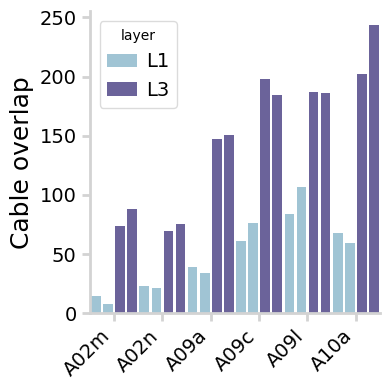

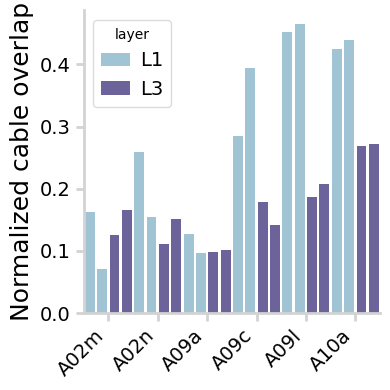

In [12]:
l1_data = l1_rank_overlap.sum(axis=0).reset_index()
l3_data = l3_rank_overlap.sum(axis=0).reset_index()
l1_data.columns = ['neuron_id', 'Cable overlap']
l3_data.columns = ['neuron_id', 'Cable overlap']
l1_data['layer'] = 'L1'
l3_data['layer'] = 'L3'

combined_data = pd.concat([l1_data, l3_data], ignore_index=True)
combined_data['cell_type'] = combined_data['neuron_id'].str.extract(r'(^[^_]+)')
combined_data = combined_data.sort_values(by=['cell_type', 'neuron_id']).reset_index(drop=True)

plt.figure(figsize=(4, 4))
ax = sns.barplot(
    data=combined_data,
    x='neuron_id', y='Cable overlap',
    hue='layer',
    palette=plot_settings.color_dict
)
ax.set_xticks([])
cell_types = combined_data['cell_type'].unique()
xticks = []
xticklabels = []
group_size = 4  # 2x L1 + 2x L3 per cell type

for i, ct in enumerate(cell_types):
    center = i * group_size + (group_size - 1) / 2
    xticks.append(center)
    xticklabels.append(ct)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45, ha='right')
ax.set_ylabel("Cable overlap")
ax.set_xlabel("")
plt.tight_layout()

# plt.savefig(path_plots+'Fig6/Fig6B.png')
# plt.savefig(path_plots+'Fig6/Fig6B.svg')


l1_norm = l1_rank_overlap.sum(axis=0) / np.diagonal(l1_overlap_dend)
l3_norm = l3_rank_overlap.sum(axis=0) / np.diagonal(l3_overlap_dend)
l1_df_norm = pd.DataFrame({
    'neuron_id': l1_rank_overlap.columns,
    'Normalized cable overlap': l1_norm,
    'layer': 'L1'
})
l3_df_norm = pd.DataFrame({
    'neuron_id': l3_rank_overlap.columns,
    'Normalized cable overlap': l3_norm,
    'layer': 'L3'
})
combined_df_norm = pd.concat([l1_df_norm, l3_df_norm], ignore_index=True)
combined_df_norm['cell_type'] = combined_df_norm['neuron_id'].str.extract(r'(^[^_]+)')
combined_df_norm = combined_df_norm.sort_values(by=['cell_type', 'neuron_id']).reset_index(drop=True)

plt.figure(figsize=(4, 4))
ax = sns.barplot(
    data=combined_df_norm,
    x='neuron_id', y='Normalized cable overlap',
    hue='layer',
    palette=plot_settings.color_dict
)
ax.set_xticks([])
xticks = []
xticklabels = []
for i, ct in enumerate(combined_df_norm['cell_type'].unique()):
    center = i * group_size + (group_size - 1) / 2
    xticks.append(center)
    xticklabels.append(ct)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45, ha='right')
ax.set_ylabel("Normalized cable overlap")
ax.set_xlabel("")
plt.tight_layout()

# plt.savefig(path_plots+'Fig6/Fig6C.png')
# plt.savefig(path_plots+'Fig6/Fig6C.svg')

Overlap fold change:

In [13]:
l1_l3_LN_df = pd.DataFrame({'Neuron': pd.concat([l1_overlap_all.sum(axis=1), l3_overlap_all.sum(axis=1)]).index.values,
                          'Instar': ['L1']*len(l1_overlap_all.sum(axis=1)) + ['L3']*len(l3_overlap_all.sum(axis=1)),
                          'Cable overlap': pd.concat([l1_rank_overlap.sum(), l3_rank_overlap.sum()]),
                          })
l1_overlap_all_norm = (l1_overlap_all.T / np.diag(l1_overlap_dend)).T
l3_overlap_all_norm = (l3_overlap_all.T / np.diag(l3_overlap_dend)).T
l1_l3_LN_df_norm = pd.DataFrame({'Neuron': pd.concat([l1_overlap_all_norm.sum(axis=1), l3_overlap_all_norm.sum(axis=1)]).index.values,
                          'Instar': ['L1']*len(l1_overlap_all_norm.sum(axis=1)) + ['L3']*len(l3_overlap_all_norm.sum(axis=1)),
                          'Normalized cable overlap': pd.concat([l1_rank_overlap.sum() / np.diagonal(l1_overlap_dend), l3_rank_overlap.sum() / np.diagonal(l3_overlap_dend)]),
                          })

In [14]:
np.median(l1_l3_LN_df[l1_l3_LN_df['Instar'] == 'L3']['Cable overlap'].values / l1_l3_LN_df[l1_l3_LN_df['Instar'] == 'L1']['Cable overlap'].values)

np.float64(3.3675762750010536)

Norm overlap fold change:

In [15]:
np.median(l1_l3_LN_df_norm[l1_l3_LN_df_norm['Instar'] == 'L3']['Normalized cable overlap'].values / l1_l3_LN_df_norm[l1_l3_LN_df_norm['Instar'] == 'L1']['Normalized cable overlap'].values)

np.float64(0.6299466014492182)

Cable overlap in L1 and L3 is significantly different:

In [16]:
# Ttest on the overlap of L1 and L3
t_stat, p_value = ttest_ind(l1_l3_LN_df[l1_l3_LN_df['Instar'] == 'L1']['Cable overlap'],
                                    l1_l3_LN_df[l1_l3_LN_df['Instar'] == 'L3']['Cable overlap'])
print('Ttest p-value:', p_value)

Ttest p-value: 3.3032776807669044e-05


### Figure 6 panel D:

pygraphviz is needed to create those plots:

INFO  : Calculating node positions. (navis)
INFO  : Plotting tree. (navis)
INFO  : Calculating node positions. (navis)
INFO  : Plotting tree. (navis)
/var/folders/gn/ytyxl_590xl1qbsb3g58w0sc0000gn/T/ipykernel_323/1426693351.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

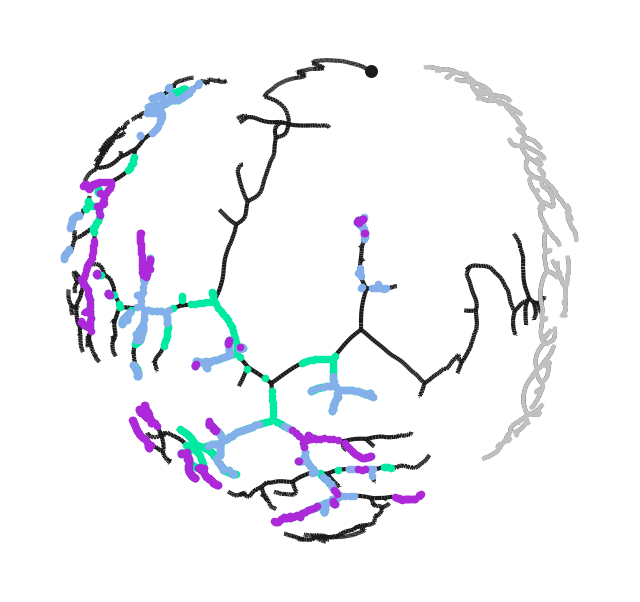

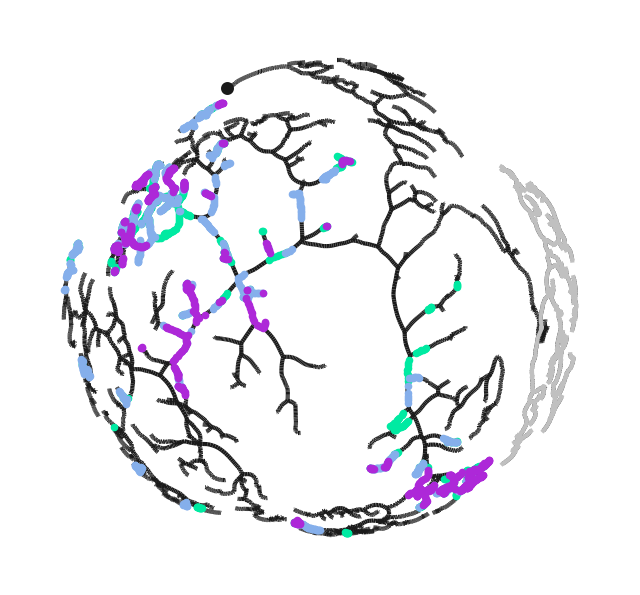

In [17]:
l1_overlap_selected_loc = l1_overlap_selected_loc.sort_values('source_name', ascending=False)
l3_overlap_selected_loc = l3_overlap_selected_loc.sort_values('source_name', ascending=False)

fig1, ax1 = plt.subplots(1, figsize=(8, 8))
fig2, ax2 = plt.subplots(1, figsize=(8, 8))

l1_ax, l1_pos = navis.plot_flat(l1_selected_overlap, layout='sfdp', ax=ax1, use_cache=False)
l3_ax, l3_pos = navis.plot_flat(l3_selected_overlap, layout='sfdp', ax=ax2, use_cache=False)

# Map 3D coords to 2D coords
l1_overlap_selected_loc['x_flat'] = [l1_pos[id][0] for id in l1_overlap_selected_loc.target_node_index]
l1_overlap_selected_loc['y_flat'] = [l1_pos[id][1] for id in l1_overlap_selected_loc.target_node_index]

l3_overlap_selected_loc['x_flat'] = [l3_pos[id][0] for id in l3_overlap_selected_loc.target_node_index]
l3_overlap_selected_loc['y_flat'] = [l3_pos[id][1] for id in l3_overlap_selected_loc.target_node_index]

# Axon
l1_LN_axon_flat = l1_LN_axons_rs[l1_LN_axons_rs.name == l1_selected_overlap.name].copy()
l1_LN_axon_flat.nodes.loc[:,'x'] = [l1_pos[id][0] for id in l1_LN_axon_flat.nodes.node_id]
l1_LN_axon_flat.nodes.loc[:,'y'] = [l1_pos[id][1] for id in l1_LN_axon_flat.nodes.node_id]
l3_LN_axon_flat = l3_LN_axons_rs[l3_LN_axons_rs.name == l3_selected_overlap.name].copy()
l3_LN_axon_flat.nodes.loc[:,'x'] = [l3_pos[id][0] for id in l3_LN_axon_flat.nodes.node_id]
l3_LN_axon_flat.nodes.loc[:,'y'] = [l3_pos[id][1] for id in l3_LN_axon_flat.nodes.node_id]

navis.plot2d(l1_LN_axon_flat, method='2d', color='silver', linewidth=3, ax=ax1)
navis.plot2d(l3_LN_axon_flat, method='2d', color='silver', linewidth=3, ax=ax2)

for collection in ax1.collections:
    collection.set_linewidth(3)

# Iterate over line collections in ax2
for collection in ax2.collections:
    collection.set_linewidth(3)

# Map the values to colors
l1_source_dict = l1_overlap_selected_loc.source_name.unique()
l3_source_dict = l3_overlap_selected_loc.source_name.unique()
cmap = plt.cm.tab10
norm = Normalize(vmin=0, vmax=10)
l1_overlap_selected_loc['color'] = l1_overlap_selected_loc['source_name'].map(plot_settings.neuron_color_dict)
l3_overlap_selected_loc['color'] = l3_overlap_selected_loc['source_name'].map(plot_settings.neuron_color_dict)

for x, y, c in zip(l1_overlap_selected_loc['x_flat'], l1_overlap_selected_loc['y_flat'],
                        l1_overlap_selected_loc['color']):
    l1_ax.scatter(x=x, y=y, color=c, s=20)

for x, y, c in zip(l3_overlap_selected_loc['x_flat'], l3_overlap_selected_loc['y_flat'],
                        l3_overlap_selected_loc['color']):
    l3_ax.scatter(x=x, y=y, color=c, s=20)

# fig1.savefig(path_plots+'Fig6/Fig6D_L1.png')
# fig2.savefig(path_plots+'Fig6/Fig6D_L3.png')

### Figure 6 panel E:

In [18]:
l1_l3_mdIV_df = pd.DataFrame({'Neuron': ['ddaC']*len(l1_ddaC_neurons) + ['v\'ada']*len(l1_vada_neurons) + ['vdaB']*len(l1_vdaB_neurons) + ['ddaC']*len(l3_ddaC_neurons) + ['v\'ada']*len(l3_vada_neurons) + ['vdaB']*len(l3_vdaB_neurons),
                          'Instar': ['L1']*len(l1_n_axon) + ['L3']*len(l3_n_axon),
                          'Cable length': [n.cable_length / 1000 for n in l1_n_axon+l3_n_axon],
                          'Presynapses': [len(n.presynapses) for n in l1_n_axon+l3_n_axon]})
l1_l3_mdIV_df['synapse density'] = (l1_l3_mdIV_df['Presynapses'] / l1_l3_mdIV_df['Cable length'])
l1_l3_mdIV_df

,Neuron,Instar,Cable length,Presynapses,synapse density
0,ddaC,L1,68.974922,50,0.724901
1,ddaC,L1,66.788170,60,0.898363
2,v'ada,L1,61.348072,47,0.766120
3,v'ada,L1,64.614182,57,0.882159
4,vdaB,L1,85.298279,43,0.504113
5,vdaB,L1,95.334427,46,0.482512
6,ddaC,L3,230.486984,274,1.188787
7,ddaC,L3,194.883408,157,0.805610
8,v'ada,L3,273.987335,247,0.901502
9,v'ada,L3,310.198639,287,0.925214


Paired t-test of L1 vs. L3 density:
T-statistic: -2.2573029909185207
P-value: 0.04758595517243751
Statistically significant.



/var/folders/gn/ytyxl_590xl1qbsb3g58w0sc0000gn/T/ipykernel_323/3766877097.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Instar', y='synapse density', data=l1_l3_mdIV_df, palette=plot_settings.color_dict)


Text(0.5, 1.2987873013224922, '*')

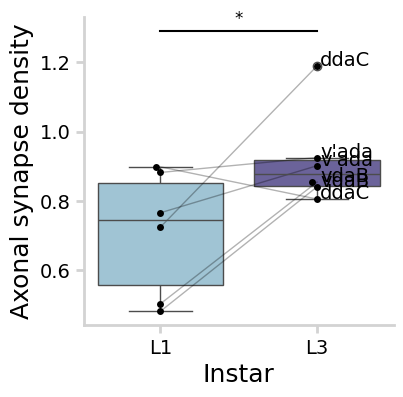

In [19]:
# # Perform paired t-test
t_stat, p_value = ttest_ind(l1_l3_mdIV_df[l1_l3_mdIV_df.Instar == 'L1']['synapse density'], l1_l3_mdIV_df[l1_l3_mdIV_df.Instar == 'L3']['synapse density'])

# Print the results
print("Paired t-test of L1 vs. L3 density:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Check significance
alpha = 0.05
if p_value < alpha:
    print("Statistically significant.\n")
else:
    print("There is no statistically significant difference.\n")

fig, ax1 = plt.subplots(1, 1, figsize=(4, 4))
sns.boxplot(x='Instar', y='synapse density', data=l1_l3_mdIV_df, palette=plot_settings.color_dict)
sns.swarmplot(x='Instar', y='synapse density', data=l1_l3_mdIV_df, ax=ax1, color='k')

for i in range(len(l1_l3_mdIV_df[l1_l3_mdIV_df.Instar == 'L1'])):
    ax1.plot([0, 1], [l1_l3_mdIV_df[l1_l3_mdIV_df.Instar == 'L1']['synapse density'].iloc[i], l1_l3_mdIV_df[l1_l3_mdIV_df.Instar == 'L3']['synapse density'].iloc[i]], color='k', linewidth=1, alpha=0.3)
for i, name in enumerate(l1_l3_mdIV_df[l1_l3_mdIV_df.Instar == 'L3'].Neuron):
    ax1.text(1.02, l1_l3_mdIV_df[l1_l3_mdIV_df.Instar == 'L3']['synapse density'].iloc[i], name, fontsize=14)
ax1.set_ylabel('Axonal synapse density')

# Set the positions for significance stars
x1, x2 = 0, 1   # Positions of the groups (x-axis)
y, h, col = l1_l3_mdIV_df['synapse density'].max() + 0.1, 0.01, 'k'  # y position, height, and color
# Add lines and significance stars
ax1.plot([x1, x2], [y, y], lw=1.5, color=col)         # Horizontal line between the groups
ax1.text((x1 + x2) * 0.5, y + h, helper.get_significance_star(p_value), ha='center', va='bottom', color=col, fontsize=12)

# plt.savefig(path_plots+'Fig6/Fig6E.png')
# plt.savefig(path_plots+'Fig6/Fig6E.svg')

### Figure 6 panel F:

In [20]:
l3_l1_overlap_ratio = l3_overlap_all / l1_overlap_all
l3_l1_overlap_ratio_norm = l3_overlap_all_norm / l1_overlap_all_norm
l3_l1_adjacency_ratio = (l3_adjacency.values / l1_adjacency.values).T
l3_l1_adjacency_ratio_norm = (l3_adjacency_norm.values / l1_adjacency_norm.values).T
l3_l1_OL_density_ratio = l3_overlap_density_all.T.values.flatten() / l1_overlap_density_all.T.values.flatten()
pre_neurons = np.repeat([name.split('_')[0] + str(i) for i, name in enumerate(l3_l1_overlap_ratio_norm.index)], l3_l1_overlap_ratio_norm.shape[1])
post_neurons = np.tile(l3_l1_overlap_ratio_norm.columns, l3_l1_overlap_ratio_norm.shape[0])

l1_l3_overlap_df = pd.DataFrame({
                                'Pre Neuron': pre_neurons,
                                'Post Neuron': post_neurons,
                                'Overlap ratio': l3_l1_overlap_ratio.values.flatten(),
                                'Overlap ratio norm': l3_l1_overlap_ratio_norm.values.flatten(),
                                'Input ratio': l3_l1_adjacency_ratio.flatten(),
                                'Input ratio norm': l3_l1_adjacency_ratio_norm.flatten(),
                                'Density ratio': l3_l1_OL_density_ratio,
                                'OL times density': l3_l1_overlap_ratio.values.flatten() * l3_l1_OL_density_ratio,
                                'OL times density norm': l3_l1_overlap_ratio_norm.values.flatten() * l3_l1_OL_density_ratio,
                                })
l1_l3_overlap_df

/var/folders/gn/ytyxl_590xl1qbsb3g58w0sc0000gn/T/ipykernel_323/470510511.py:3: RuntimeWarning: divide by zero encountered in divide
  l3_l1_adjacency_ratio = (l3_adjacency.values / l1_adjacency.values).T
/var/folders/gn/ytyxl_590xl1qbsb3g58w0sc0000gn/T/ipykernel_323/470510511.py:3: RuntimeWarning: invalid value encountered in divide
  l3_l1_adjacency_ratio = (l3_adjacency.values / l1_adjacency.values).T
/var/folders/gn/ytyxl_590xl1qbsb3g58w0sc0000gn/T/ipykernel_323/470510511.py:4: RuntimeWarning: divide by zero encountered in divide
  l3_l1_adjacency_ratio_norm = (l3_adjacency_norm.values / l1_adjacency_norm.values).T
/var/folders/gn/ytyxl_590xl1qbsb3g58w0sc0000gn/T/ipykernel_323/470510511.py:4: RuntimeWarning: invalid value encountered in divide
  l3_l1_adjacency_ratio_norm = (l3_adjacency_norm.values / l1_adjacency_norm.values).T
/var/folders/gn/ytyxl_590xl1qbsb3g58w0sc0000gn/T/ipykernel_323/470510511.py:5: RuntimeWarning: divide by zero encountered in divide
  l3_l1_OL_density_ratio

,Pre Neuron,Post Neuron,Overlap ratio,Overlap ratio norm,Input ratio,Input ratio norm,Density ratio,OL times density,OL times density norm
0,A02m0,ddaC,3.383404,0.510419,6.500000,1.040850,1.921142,6.500000,0.980588
1,A02m0,ddaC,9.124849,1.376572,19.000000,3.042484,2.082226,19.000000,2.866334
2,A02m0,v'ada,1.353678,0.204215,2.000000,0.320261,1.477456,2.000000,0.301719
3,A02m0,v'ada,inf,inf,inf,inf,inf,inf,inf
4,A02m0,vdaB,4.231230,0.638322,0.333333,0.053377,0.078779,0.333333,0.050287
...,...,...,...,...,...,...,...,...,...
67,A10a11,ddaC,88.996016,13.514139,inf,inf,inf,inf,inf
68,A10a11,v'ada,1.356652,0.206009,1.285714,0.218447,0.947711,1.285714,0.195237
69,A10a11,v'ada,inf,inf,inf,inf,inf,inf,inf
70,A10a11,vdaB,3.883649,0.589736,5.272727,0.895852,1.357673,5.272727,0.800669


r = 0.6954721413077717, p = 4.109943185914823e-08, r^2 = 0.2514483667153551
r = 0.9622441381417848, p = 1.2250548161728974e-27 , r^2 = 0.8965940529383986


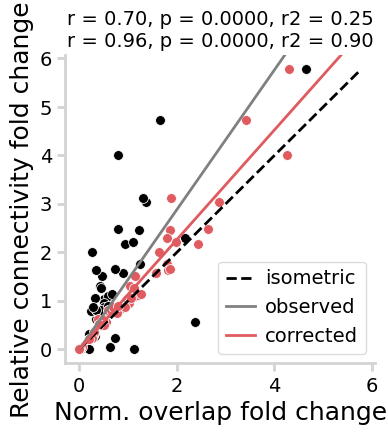

In [21]:
# Change input ratio that are higher than 10 to NaN
l1_l3_overlap_df_filtered = l1_l3_overlap_df.replace([np.inf, -np.inf], np.nan).dropna()

# Ensure numeric columns are used
fig, ax1 = plt.subplots(1, 1, figsize=(4, 4))

# Switch x and y for scatter plots
sns.scatterplot(data=l1_l3_overlap_df_filtered, x='Overlap ratio norm', y='Input ratio norm', ax=ax1, color='k', s=50)
sns.scatterplot(data=l1_l3_overlap_df_filtered, x='OL times density norm', y='Input ratio norm', ax=ax1, color=plot_settings.axon_color, s=50)

# Perform linear regression without an intercept (force through origin)
b = l1_l3_overlap_df_filtered['Input ratio norm'].values
A = l1_l3_overlap_df_filtered['Overlap ratio norm'].values.reshape(-1, 1)
model = lsq_linear(A, b)

b2 = l1_l3_overlap_df_filtered['Input ratio norm'].values
A2 = l1_l3_overlap_df_filtered['OL times density norm'].values.reshape(-1, 1)
model2 = lsq_linear(A2, b2)

x = l1_l3_overlap_df_filtered['Overlap ratio norm'].values
y = l1_l3_overlap_df_filtered['Input ratio norm'].values

# Fit Huber Regressor
huber = HuberRegressor(epsilon=1.35)
huber.fit(x.reshape(-1, 1), y)

# Predict regression line
x_range = np.linspace(min(x), max(x), 100)
y_pred = huber.predict(x_range.reshape(-1, 1))

# Perform Pearson correlation
r_value, p_value = pearsonr(l1_l3_overlap_df_filtered['Input ratio norm'], l1_l3_overlap_df_filtered['Overlap ratio norm'])
r_value2, p_value2 = pearsonr(l1_l3_overlap_df_filtered['Input ratio norm'], l1_l3_overlap_df_filtered['OL times density norm'])


r_squared = r2_score(l1_l3_overlap_df_filtered['Input ratio norm'], l1_l3_overlap_df_filtered['Overlap ratio norm'])
# r_squared = r2_score(l1_l3_overlap_df_filtered['Overlap ratio norm'], l1_l3_overlap_df_filtered['Input ratio norm'])
r_squared2 = r2_score(l1_l3_overlap_df_filtered['Input ratio norm'], l1_l3_overlap_df_filtered['OL times density norm'])
# r_squared2 = r2_score(l1_l3_overlap_df_filtered['OL times density norm'], l1_l3_overlap_df_filtered['Input ratio norm'])

print(f"r = {r_value}, p = {p_value}, r^2 = {r_squared}")
print(f"r = {r_value2}, p = {p_value2} , r^2 = {r_squared2}")

max_filtered = l1_l3_overlap_df_filtered[['Overlap ratio norm', 'Input ratio norm']].max().max()
ax1.plot([0, max_filtered], [0, max_filtered], color='k', linestyle='--', label='isometric')
# Plot regression lines
ax1.plot([0, max_filtered], [0, model.x[0] * max_filtered], color='grey', label='observed')
ax1.plot([0, max_filtered], [0, model2.x[0] * max_filtered], color=plot_settings.axon_color, label='corrected')

# Update title and labels
ax1.set_title(f'r = {r_value:.2f}, p = {p_value:.4f}, r2 = {r_squared:.2f}\nr = {r_value2:.2f}, p = {p_value2:.4f}, r2 = {r_squared2:.2f}', fontsize=14)
ax1.set_xlabel('Norm. overlap fold change')
ax1.set_ylabel('Relative connectivity fold change')
ax1.set_ylim(ax1.get_xlim())
ax1.legend()

# plt.savefig(path_plots+'Fig6/Fig6F.png')
# plt.savefig(path_plots+'Fig6/Fig6F.svg')

## Supplementary Figure 6 S4

### Supp. Figure 6 S4 panel A:

Mean L3/L1 ratio: 3.0809079445662797
Mean L3/L1 ratio norm: 0.5741707684805477


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'A02m'),
  Text(1, 0, 'A02n'),
  Text(2, 0, 'A09a'),
  Text(3, 0, 'A09c'),
  Text(4, 0, 'A09l'),
  Text(5, 0, 'A10a')])

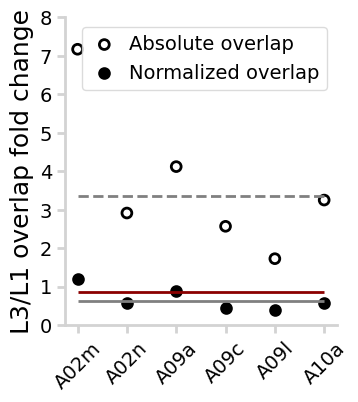

In [22]:
l1_overlap_all_norm = (l1_overlap_all.T / np.diag(l1_overlap_dend)).T
l3_overlap_all_norm = (l3_overlap_all.T / np.diag(l3_overlap_dend)).T

l1_grouped_df = l1_overlap_all.groupby(l1_overlap_all.index)
l3_grouped_df = l3_overlap_all.groupby(l3_overlap_all.index)
l1_grouped_df_norm = l1_overlap_all_norm.groupby(l1_overlap_all_norm.index)
l3_grouped_df_norm = l3_overlap_all_norm.groupby(l3_overlap_all_norm.index)

l1_sum_df = l1_grouped_df.sum().T.sum()
l3_sum_df = l3_grouped_df.sum().T.sum()
l1_sum_df_norm = l1_grouped_df_norm.sum().T.sum()
l3_sum_df_norm = l3_grouped_df_norm.sum().T.sum()


l3_l1_overlap_ratio = l3_sum_df / l1_sum_df
l3_l1_overlap_ratio_norm = l3_sum_df_norm / l1_sum_df_norm

# Plot L3/L1 fraction with diamond markers
fig, ax = plt.subplots(figsize=(3.5, 4))
sns.scatterplot(data=l3_l1_overlap_ratio, label='Absolute overlap',  fc='none', edgecolor='k', s=50, linewidth=2)
sns.scatterplot(data=l3_l1_overlap_ratio_norm, label='Normalized overlap', c='k', s=50, edgecolor='k', linewidth=2)
ax.hlines([np.median(l1_l3_LN_df[l1_l3_LN_df['Instar'] == 'L3']['Cable overlap'].values / l1_l3_LN_df[l1_l3_LN_df['Instar'] == 'L1']['Cable overlap'].values),
           np.median(l1_l3_LN_df_norm[l1_l3_LN_df_norm['Instar'] == 'L3']['Normalized cable overlap'].values / l1_l3_LN_df_norm[l1_l3_LN_df_norm['Instar'] == 'L1']['Normalized cable overlap'].values),
           np.median(l1_l3_LN_df_norm[l1_l3_LN_df_norm['Instar'] == 'L3']['Normalized cable overlap'].values / l1_l3_LN_df_norm[l1_l3_LN_df_norm['Instar'] == 'L1']['Normalized cable overlap'].values) * 1.37
           ], 0, 5, colors=['grey','grey','darkred'], linestyles=['--','-', '-'])

print('Mean L3/L1 ratio:', l3_l1_overlap_ratio.median())
print('Mean L3/L1 ratio norm:', l3_l1_overlap_ratio_norm.median())

ax.set_ylabel('L3/L1 overlap fold change')
ax.set_yticks(range(0,9,1))
plt.xticks(rotation=45)

# plt.savefig(path_plots+'Fig6/Fig6S4A.png')
# plt.savefig(path_plots+'Fig6/Fig6S4A.svg')

### Supp. Figure 6 S4 panel B:

In [23]:
l1_all_neurons = l1_A02m_neurons + l1_A02n_neurons + l1_A09a_neurons + l1_A09c_neurons + l1_A09l_neurons + l1_A10a_neurons
l3_all_neurons = l3_A02m_neurons + l3_A02n_neurons + l3_A09a_neurons + l3_A09c_neurons + l3_A09l_neurons + l3_A10a_neurons

# l1_all_neurons_split = navis.morpho.split_axon_dendrite(l1_all_neurons, reroot_soma=True, cellbodyfiber='soma')
l1_all_neurons_split = helper.try_with_retries(navis.morpho.split_axon_dendrite, 5, l1_all_neurons, reroot_soma=True, cellbodyfiber='soma')
# l3_all_neurons_split = navis.morpho.split_axon_dendrite(l3_all_neurons, reroot_soma=True, cellbodyfiber='soma')
l3_all_neurons_split = helper.try_with_retries(navis.morpho.split_axon_dendrite, 5, l3_all_neurons, reroot_soma=True, cellbodyfiber='soma')

all_neurons_split = l1_all_neurons_split + l3_all_neurons_split
all_neurons = all_neurons_split[all_neurons_split.compartment == 'dendrite']

df_LNs = pd.DataFrame({'Neuron': ['A02m']*len(l1_A02m_neurons) + ['A02n']*len(l1_A02n_neurons) + ['A09a']*len(l1_A09a_neurons) + ['A09c']*len(l1_A09c_neurons) + ['A09l']*len(l1_A09l_neurons) + ['A10a']*len(l1_A10a_neurons) + ['A02m']*len(l3_A02m_neurons) + ['A02n']*len(l3_A02n_neurons) + ['A09a']*len(l3_A09a_neurons) + ['A09c']*len(l3_A09c_neurons) + ['A09l']*len(l3_A09l_neurons) + ['A10a']*len(l3_A10a_neurons),
# df_LNs = pd.DataFrame({'Neuron': all_neurons.name,
                          'Instar': ['L1']*len(l1_A02m_neurons + l1_A02n_neurons + l1_A09a_neurons + l1_A09c_neurons + l1_A09l_neurons + l1_A10a_neurons) + ['L3']*len(l3_A02m_neurons + l3_A02n_neurons + l3_A09a_neurons + l3_A09c_neurons + l3_A09l_neurons + l3_A10a_neurons),
                          'Cable length': [n.cable_length / 1000 for n in all_neurons],
                          'Postsynapses': [len(n.postsynapses) for n in all_neurons]})
df_LNs['synapse density'] = (df_LNs['Postsynapses'] / df_LNs['Cable length'])

df_LNs

Splitting:   0%|          | 0/12 [00:00<?, ?it/s]

Splitting:   0%|          | 0/12 [00:00<?, ?it/s]

,Neuron,Instar,Cable length,Postsynapses,synapse density
0,A02m,L1,92.759331,45,0.485126
1,A02m,L1,107.560524,64,0.595014
2,A02n,L1,90.809952,62,0.682745
3,A02n,L1,144.127518,65,0.450990
4,A09a,L1,317.096069,273,0.860938
5,A09a,L1,362.203247,325,0.897286
6,A09c,L1,224.705872,181,0.805497
7,A09c,L1,202.912720,147,0.724449
8,A09l,L1,192.208878,173,0.900062
9,A09l,L1,237.729568,223,0.938041


T-test L1 axonal density vs L1 density within overlap: p-value = 0.9823836930224845
T-test L3 axonal density vs L3 density within overlap: p-value = 0.020794417863931488
T-test L3 axonal density corrected vs L3 density within overlap: p-value = 0.18392608289011167


/var/folders/gn/ytyxl_590xl1qbsb3g58w0sc0000gn/T/ipykernel_323/2342668861.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=categories, y=y, palette=[plot_settings.axon_color, plot_settings.axon_color, plot_settings.dendrite_color], ax=ax1)


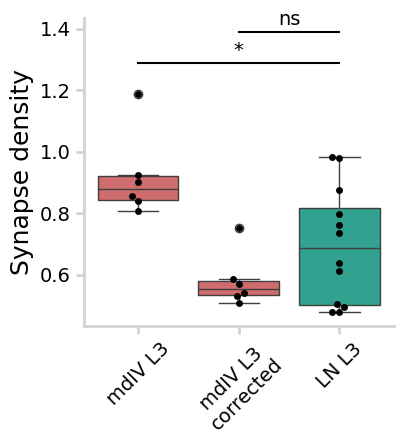

In [33]:
# overlap_scalar = 0.772
overlap_scalar = 0.632

# Test L1 dendrite density vs L1 density within overlap
t_stat_data, p_value_data = ttest_ind(l1_l3_mdIV_df[l1_l3_mdIV_df.Instar == 'L1']['synapse density'].values,
    df_LNs[df_LNs.Instar == 'L1']['synapse density'].values)

print(f'T-test L1 axonal density vs L1 density within overlap: p-value = {p_value_data}')

# Test L1 dendrite density vs L1 density within overlap
t_stat_data, p_value_data = ttest_ind(l1_l3_mdIV_df[l1_l3_mdIV_df.Instar == 'L3']['synapse density'].values,
    df_LNs[df_LNs.Instar == 'L3']['synapse density'].values)

print(f'T-test L3 axonal density vs L3 density within overlap: p-value = {p_value_data}')

t_stat_corrected, p_value_corrected = ttest_ind(l1_l3_mdIV_df[l1_l3_mdIV_df.Instar == 'L3']['synapse density'].values * overlap_scalar,
    df_LNs[df_LNs.Instar == 'L3']['synapse density'].values)

print(f'T-test L3 axonal density corrected vs L3 density within overlap: p-value = {p_value_corrected}')

fig, ax1 = plt.subplots(1, 1, figsize=(4, 4))

# Prepare data for boxplot
x = ['mdIV L3', 'mdIV L3 corrected', 'LN L3']
y = np.concatenate([
    l1_l3_mdIV_df[l1_l3_mdIV_df.Instar == 'L3']['synapse density'].values,
    l1_l3_mdIV_df[l1_l3_mdIV_df.Instar == 'L3']['synapse density'].values * overlap_scalar,
    df_LNs[df_LNs.Instar == 'L3']['synapse density'].values
])
categories = np.concatenate([
    np.repeat('mdIV L3', len(l1_l3_mdIV_df[l1_l3_mdIV_df.Instar == 'L3'])),
    np.repeat('mdIV L3\ncorrected', len(l1_l3_mdIV_df[l1_l3_mdIV_df.Instar == 'L3'])),
    np.repeat('LN L3', len(df_LNs[df_LNs.Instar == 'L3']))
])

sns.boxplot(x=categories, y=y, palette=[plot_settings.axon_color, plot_settings.axon_color, plot_settings.dendrite_color], ax=ax1)
sns.swarmplot(x=categories, y=y, color='k', ax=ax1)

# rotate the x-axis labels
plt.ylabel('Synapse density')
plt.xticks(rotation=45)

# Add significance stars
# Set the positions for significance stars
x1, x2 = 0, 2   # Positions of the groups (x-axis)
y, h, col = y.max() + 0.1, 0.01, 'k'  # y position, height, and color
# Add lines and significance stars
ax1.plot([x1, x2], [y, y], lw=1.5, color=col)         # Horizontal line between the groups
ax1.text((x1 + x2) * 0.5, y + h, helper.get_significance_star(p_value_data), ha='center', va='bottom', color=col, fontsize=14)

# Set the positions for significance stars
x1, x2 = 1, 2   # Positions of the groups (x-axis)
y, h, col = y.max() + 0.1, 0.01, 'k'  # y position, height, and color
# Add lines and significance stars
ax1.plot([x1, x2], [y, y], lw=1.5, color=col)         # Horizontal line between the groups
ax1.text((x1 + x2) * 0.5, y + h, helper.get_significance_star(p_value_corrected), ha='center', va='bottom', color=col, fontsize=14)


# plt.savefig(path_plots + 'Fig6/Fig6S4B.png')
# plt.savefig(path_plots + 'Fig6/Fig6S4B.svg')